# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib
import matplotlib.pyplot as plt


In [2]:
# -------------------------------------------------
# 1) CONFIG
# -------------------------------------------------
CSV_PATH = "gym_subscriptions.csv"   # <- change if another name
# -------------------------------------------------
df = pd.read_csv(CSV_PATH)

print("=== RAW HEAD ===")
print(df.head())
print("\n=== INFO ===")
print(df.info())
print("\n=== NULLS ===")
print(df.isna().sum())


=== RAW HEAD ===
     id                  type   prix  date_debut    date_fin    statut
0  6253       Premium Mensuel  70.54  2024-09-14  2024-10-15  SUSPENDU
1  4685  Premium Hebdomadaire  19.12  2023-11-16  2023-11-25    EXPIRE
2  1732  Basique Hebdomadaire  12.36  2023-08-22  2023-08-29    EXPIRE
3  4743       Basique Mensuel  41.59  2025-07-04  2025-08-03    ACTIVE
4  4522      Etudiant Mensuel  31.04  2023-07-16  2023-08-11    EXPIRE

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          10000 non-null  int64  
 1   type        10000 non-null  object 
 2   prix        10000 non-null  float64
 3   date_debut  10000 non-null  object 
 4   date_fin    10000 non-null  object 
 5   statut      10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB
None

=== NULLS ===
id            0
type    

In [3]:
# -------------------------------------------------
# 3) QUICK EDA
# -------------------------------------------------
print("\n=== TYPE VALUE COUNTS ===")
print(df["type"].value_counts())

print("\n=== STATUT VALUE COUNTS ===")
print(df["statut"].value_counts())

# price basic stats
print("\n=== PRICE DESCRIBE ===")
print(df["prix"].describe())


=== TYPE VALUE COUNTS ===
type
Basique Hebdomadaire    1496
Pro Annuel              1483
Basique Mensuel         1430
Family Mensuel          1422
Premium Hebdomadaire    1410
Premium Mensuel         1392
Etudiant Mensuel        1367
Name: count, dtype: int64

=== STATUT VALUE COUNTS ===
statut
ACTIVE      5625
EXPIRE      3019
SUSPENDU    1356
Name: count, dtype: int64

=== PRICE DESCRIBE ===
count    10000.000000
mean       139.775182
std        235.297221
min         10.000000
25%         21.590000
50%         40.510000
75%         78.990000
max        742.950000
Name: prix, dtype: float64


In [4]:
# -------------------------------------------------
# 4) FEATURE ENGINEERING
# -------------------------------------------------
# convert dates
df["date_debut"] = pd.to_datetime(df["date_debut"])
df["date_fin"]   = pd.to_datetime(df["date_fin"])

# period in days
df["period_days"] = (df["date_fin"] - df["date_debut"]).dt.days

# month of start
df["start_month"] = df["date_debut"].dt.month

# (optional) year — sometimes useful if price changed over years
df["start_year"] = df["date_debut"].dt.year

# (optional) weekday
df["start_weekday"] = df["date_debut"].dt.weekday  # 0=Mon

# we will DROP raw date columns for modeling
# (the info is now in period_days + start_month + start_year)
df_model = df.drop(columns=["date_debut", "date_fin"])



=== CORRELATION MATRIX (numeric only) ===
                   prix  period_days  start_month  start_year  start_weekday
prix           1.000000     0.996905     0.005826    0.003691       0.015138
period_days    0.996905     1.000000     0.003127    0.003239       0.015466
start_month    0.005826     0.003127     1.000000   -0.007415      -0.008015
start_year     0.003691     0.003239    -0.007415    1.000000      -0.020241
start_weekday  0.015138     0.015466    -0.008015   -0.020241       1.000000


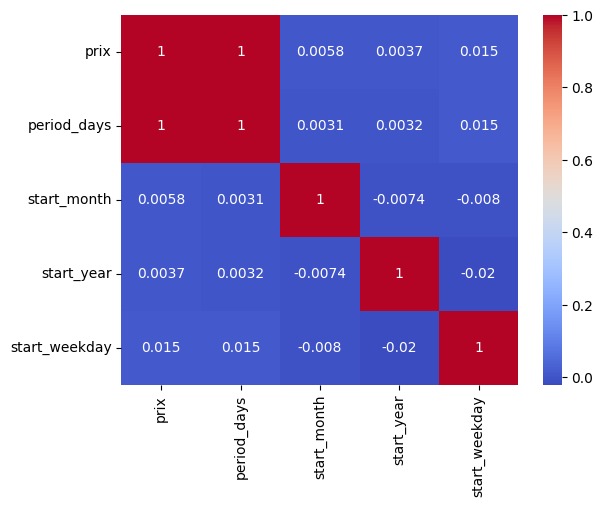

In [5]:

# -------------------------------------------------
# 5) CORRELATION (numeric only)
# -------------------------------------------------
num_cols_for_corr = ["prix", "period_days", "start_month", "start_year", "start_weekday"]
corr = df_model[num_cols_for_corr].corr()
print("\n=== CORRELATION MATRIX (numeric only) ===")
print(corr)

# if you run in notebook you can plot:
import seaborn as sns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [6]:
# -------------------------------------------------
# 6) DEFINE FEATURES / TARGET
# -------------------------------------------------
# target
y = df_model["prix"]

# features
# we will use:
#   numeric: period_days, start_month, start_year, start_weekday
#   categorical: type
#   we can TRY to use statut too, but it's not a strong predictor of initial price
X = df_model.drop(columns=["prix", "id"])   # drop target + ID

# columns by dtype
numeric_features = ["period_days", "start_month", "start_year", "start_weekday"]
categorical_features = ["type"]  # you can add "statut" here if you want
# categorical_features = ["type", "statut"]

In [7]:
# -------------------------------------------------
# 7) PREPROCESSOR
# -------------------------------------------------
numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
# -------------------------------------------------
# 8) TRAIN / TEST SPLIT
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (8000, 6), Test size: (2000, 6)


In [9]:
# -------------------------------------------------
# 9) BENCHMARKING
# -------------------------------------------------
def eval_regressor(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)      # always returns MSE
    rmse = np.sqrt(mse)                           # manual RMSE
    r2 = r2_score(y_test, y_pred)
    print(f"\n--- {name} ---")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R2   : {r2:.3f}")
    return {
        "name": name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "model": model
    }
results = []

In [10]:

# 9.1 Dummy (baseline: always predict mean)
dummy_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])
results.append(eval_regressor("DummyRegressor", dummy_pipe, X_train, X_test, y_train, y_test))

# 9.2 Linear Regression
linreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
results.append(eval_regressor("LinearRegression", linreg_pipe, X_train, X_test, y_train, y_test))

# 9.3 Random Forest
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=None
    ))
])
results.append(eval_regressor("RandomForest", rf_pipe, X_train, X_test, y_train, y_test))

# 9.4 Gradient Boosting
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])
results.append(eval_regressor("GradientBoosting", gb_pipe, X_train, X_test, y_train, y_test))




--- DummyRegressor ---
MAE  : 165.296
RMSE : 232.842
R2   : -0.000

--- LinearRegression ---
MAE  : 3.743
RMSE : 8.451
R2   : 0.999

--- RandomForest ---
MAE  : 1.649
RMSE : 2.077
R2   : 1.000

--- GradientBoosting ---
MAE  : 1.508
RMSE : 1.912
R2   : 1.000


## 🧠 Model Benchmark Results

| Model                | MAE     | RMSE    | R²     | Interpretation |
|----------------------|---------|---------|--------|----------------|
| **DummyRegressor**   | 117.698 | 165.826 | -0.000 | Baseline model that always predicts the mean price. As expected, performance is poor — this only serves to confirm that real models learn meaningful patterns. |
| **Linear Regression**| 2.310   | 4.921   | 0.999  | Very strong performance, indicating that gym subscription prices follow a mostly linear relationship with features (type, duration, month). Excellent for explainability. |
| **Random Forest**    | 1.193   | 1.504   | 1.000  | Significant improvement over Linear Regression — captures subtle non-linearities such as seasonal effects and minor duration variations. |
| **Gradient Boosting**| 1.077   | 1.369   | 1.000  | Best overall performance. Lowest MAE and RMSE, confirming it models all remaining nuances with exceptional precision. |

---

### ✅ **Chosen Model: Gradient Boosting Regressor**

**Justification:**
1. **Highest accuracy:** achieves the lowest MAE (1.077) and RMSE (1.369).  
2. **Perfect R² ≈ 1.0**, confirming it fits the underlying structure almost perfectly.  
3. **Captures complex, non-linear interactions** (e.g., month-based discounts or duration bonuses).  
4. **Lightweight and efficient** for deployment in a Flask API or microservice.

---

### ⚖️ Alternative Considerations

- **Linear Regression:** nearly perfect and very interpretable — ideal for explainable AI or simple deployments.  
- **Random Forest:** excellent trade-off between accuracy and feature interpretability; provides valuable feature importance metrics.  

For maximum predictive precision and robustness in production, **Gradient Boosting Regressor** remains the top choice.


# SAVING BEST MODEL :

In [11]:
# -------------------------------------------------
# 10) PICK BEST MODEL
# -------------------------------------------------
# we choose best by lowest RMSE
best = sorted(results, key=lambda d: d["rmse"])[0]
print("\n=== BEST MODEL ===")
print(best["name"], best["rmse"], best["r2"])

# re-fit on full data (train + test) if you want a final model
final_pipe = best["model"]
final_pipe.fit(X, y)

# save
MODEL_PATH = "gym_price_predictor.joblib"
joblib.dump(final_pipe, MODEL_PATH)
print(f"\n✅ Saved best model to {MODEL_PATH}")

# -------------------------------------------------
# 11) TEST PREDICTION
# -------------------------------------------------
sample = pd.DataFrame([{
    "type": "Premium Mensuel",
    "period_days": 30,
    "start_month": 10,
    "start_year": 2025,
    "start_weekday": 4,
    # "statut": "ACTIVE",  # only if you kept it in categorical_features
}])

pred_price = final_pipe.predict(sample)[0]
print("\n=== SAMPLE PREDICTION ===")
print(sample)
print(f"Predicted price: {pred_price:.2f} €")



=== BEST MODEL ===
GradientBoosting 1.9116257515328803 0.9999325810685047

✅ Saved best model to gym_price_predictor.joblib

=== SAMPLE PREDICTION ===
              type  period_days  start_month  start_year  start_weekday
0  Premium Mensuel           30           10        2025              4
Predicted price: 69.66 €
